In [2]:

from PIL import Image
import numpy as np

image = Image.open('/home/u-ril/project-tracey/streaming/baseofcoffee.png')
image = np.asanyarray(image)

In [25]:
import google.generativeai as genai
from PIL import Image
from dotenv import load_dotenv
import os
import base64
import io
import json
from IPython.display import HTML, display
from PIL import Image, ImageDraw
import numpy as np
import re
load_dotenv()
GOOGLE_GENAI_API_KEY = os.getenv("GOOGLE_GENAI_API_KEY") # Gemini API key has been loaded into the .env file

class GeminiModel():
    def __init__(self):
        # set up the model
        genai.configure(api_key=GOOGLE_GENAI_API_KEY)

        generation_config = {
            "temperature": 0.5,
        }

        system_instructions = """You are a super intelligent AI model that is in control of a robot arm. Your input is a scene with a robotic arm and you will output commands for the robotic arm.
                                 You will follow ALL instructions exactly as expreessed.
                                 You are paired with a robot camera. This robot camera is stationary. Your main task is to infer the user's intentions based off their gaze.
                                 In other words, figure out what the user wants to do with the object that they are staring at."""

        self.model = genai.GenerativeModel(
            model_name = 'gemini-2.0-flash-exp',
            generation_config=generation_config,
            system_instruction=system_instructions,
        )

    def inference3D(self, scene):
        if type(scene) is not Image.Image:
            scene = Image.fromarray(scene)

        # Analyze the image using Gemini
        response = self.model.generate_content(
            [
                scene,
                """
                # Background
                A user is looking at the screen. There is a bright green dot on the screen where the user is looking. Based on the object that the user is looking at, think to yourself:
                    1. What is the user looking at? Detect the 3D bounding box of this object.
                    2. In the context of the scene, what is the important and or relevance of this object?
                    3. Are there other objects In this scene that may or may not interact with the object the user is looking at?
                    4. What could the user possibly want to do with the object?
                    5. What is the most likely action that the user would want to do with this object?
                
                # Instructions:
                Following the chain of thought in the above background section, deduce what the user wants to do with the object.
                Identify the IMMEDIATE next step to achieve what you believe the user wants to do. If there are many possibilities of what the user maay want to do, take the next logical action that overlaps with many different possible end goals.
                
                Then, Detect the 3D bounding box of the object.

                Output a json list where the next course of action uses the key "action", the "object" and its 3D bounding box in "box_3d"
                The 3D bounding box format should be [x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw].

                ```json\n[\n  {\n    \"action\": \"pick\",\n\"object\": \"cup\", \n    \"box_3d\": [-0.14,3.74,-0.71,0.76,0.59,1.08,0,0,0]\n  }\n]\n```
                """
            ],
        )

        print(response.text)
        return response

    def inference2D(self, scene):
        if type(scene) is not Image.Image:
            height, width = scene.shape[:2]
            scene = Image.fromarray(scene)

        scene = scene.resize((800, int(800 * scene.size[1] / scene.size[0])), Image.Resampling.LANCZOS) # Resizing to speed-up rendering

        # Analyze the image using Gemini
        response = self.model.generate_content(
            [
                scene,
                """
                # Background
                A user is looking at the screen. There is a bright green dot on the screen where the user is looking. Based on the object that the user is looking at, think to yourself:
                    1. What is the user looking at? Detect the 3D bounding box of this object.
                    2. In the context of the scene, what is the important and or relevance of this object?
                    3. Are there other objects In this scene that may or may not interact with the object the user is looking at?
                    4. What could the user possibly want to do with the object?
                    5. What is the most likely action that the user would want to do with this object?
                
                # Instructions:
                Following the chain of thought in the above background section, deduce what the user wants to do with the object.
                Identify the IMMEDIATE next step to achieve what you believe the user wants to do. If there are many possibilities of what the user maay want to do, take the next logical action that overlaps with many different possible end goals.
                
                Then, bound the object.

                Output following the json format: [{"action": , "box_2d": }, ...].
                The 2D bounding box format should be [y_min, x_min, y_max, x_max] format normalized to 0-1000.
                """
            ],
        )

        # Check response
        print(response)
        return response
    



    def inference3D2(self, scene):
        if not isinstance(scene, Image.Image):
            scene = Image.fromarray(scene)

        # Analyze the image using Gemini
        response = self.model.generate_content(
            [
                scene,
                """
                # Background
                A user is looking at the screen. There is a bright green dot on the screen where the user is looking. Based on the object that the user is looking at, think to yourself:
                    1. What is the user looking at? Detect the 3D bounding box of this object.
                    2. In the context of the scene, what is the important and or relevance of this object?
                    3. Are there other objects In this scene that may or may not interact with the object the user is looking at?
                    4. What could the user possibly want to do with the object?
                    5. What is the most likely action that the user would want to do with this object?

                # Instructions:
                Following the chain of thought in the above background section, deduce what the user wants to do with the object.
                Identify the IMMEDIATE next step to achieve what you believe the user wants to do. If there are many possibilities of what the user may want to do, take the next logical action that overlaps with many different possible end goals.

                Then, Detect the 3D bounding box of the object.

                Output a json list where the next course of action uses the key "action", the "object" and its 3D bounding box in "box_3d"
                The 3D bounding box format should be [x_center, y_center, z_size, roll, pitch, yaw].

                ```json\n[\n  {\n    \"action\": \"pick\",\n\"object\": \"cup\", \n    \"box_3d\": [-0.14,3.74,-0.71,0.76,0.59,1.08,0,0,0]\n  }\n]\n```
                """
            ],
        )

        print(response.text)
        try:
            json_data = json.loads(response.text)
            if json_data and isinstance(json_data, list) and len(json_data) > 0:
                
                bounding_box_data = json_data[0].get("box_3d")
                
                if bounding_box_data:
                    # Extract bounding box parameters
                    x_center, y_center, z_center, x_size, y_size, z_size = bounding_box_data

                    # Calculate 2D bounding box coordinates (projection to 2D, approximation)
                    # Since we dont have camera parameters, use a simple approximation
                    x1 = x_center - x_size / 2
                    y1 = y_center - y_size / 2
                    x2 = x_center + x_size / 2
                    y2 = y_center + y_size / 2

                    # Create a copy of the original image
                    image_with_box = scene.copy()
                    draw = ImageDraw.Draw(image_with_box)
                    
                    # Draw the bounding box
                    draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
                    
                    # Convert the image to base64 for display
                    buffered = io.BytesIO()
                    image_with_box.save(buffered, format="PNG")
                    img_str = base64.b64encode(buffered.getvalue()).decode()

                    # Display the image with bounding box in Jupyter Notebook
                    display(HTML(f'<img src="data:image/png;base64,{img_str}">'))
                else:
                    print("No 'box_3d' data found in JSON response.")

        except json.JSONDecodeError:
            print("Error decoding JSON response.")
        except Exception as e:
            print(f"An error occurred: {e}")
        return response


In [26]:

gemini_model = GeminiModel()
result2d = gemini_model.inference2D(image)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```json\n[\n  {\n    \"action\": \"move_to_object\",\n    \"box_2d\": [500, 277, 550, 373]\n  }\n]\n```\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "probability": "NEGLIGIBLE"
            }
          

In [23]:

gemini_model = GeminiModel()
result3d = gemini_model.inference3D2(image)
result2d = gemini_model.inference2D(image)

```json
[
  {
    "action": "pick",
    "object": "cup",
    "box_3d": [0.06,0.75,0.0,0.08,0.08,0.07,0,0,-37]
  }
]
```

Error decoding JSON response.
response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "```json\n[\n  {\n    \"action\": \"point\",\n    \"point\": [\n      266,\n      508\n    ]\n  }\n]\n```\n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
    

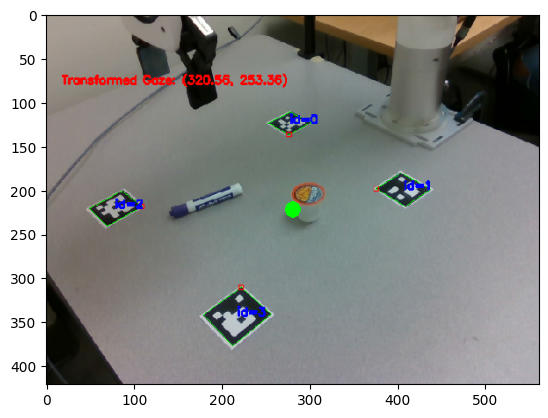

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Image path
image_path = '/home/u-ril/project-tracey/streaming/baseofcoffee.png'
image = cv2.imread(image_path)

# Bounding box parameters
x_center, y_center, z_center = 0.01, 0.52, -0.02
x_size, y_size, z_size = 0.08, 0.08, 0.11
roll, pitch, yaw = 0, 0, -36

# Convert degrees to radians for rotation
yaw = np.radians(yaw)

# Function to plot the 3D bounding box
def plot_bbox(image, x_center, y_center, z_center, x_size, y_size, z_size, yaw):
    # Create a figure
    fig, ax = plt.subplots()

    # Plot the original image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Define the corners of the bounding box
    corners = np.array([
        [x_center - x_size / 2, y_center - y_size / 2],
        [x_center + x_size / 2, y_center - y_size / 2],
        [x_center + x_size / 2, y_center + y_size / 2],
        [x_center - x_size / 2, y_center + y_size / 2]
    ])

    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw)],
        [np.sin(yaw), np.cos(yaw)]
    ])

    # Rotate corners
    rotated_corners = np.dot(corners - [x_center, y_center], rotation_matrix.T) + [x_center, y_center]

    # Plot bounding box
    box = plt.Polygon(rotated_corners, fill=None, edgecolor='red')
    ax.add_patch(box)

    plt.show()

# Plot the bounding box
plot_bbox(image, x_center, y_center, z_center, x_size, y_size, z_size, yaw)


ValueError: not enough values to unpack (expected 2, got 1)

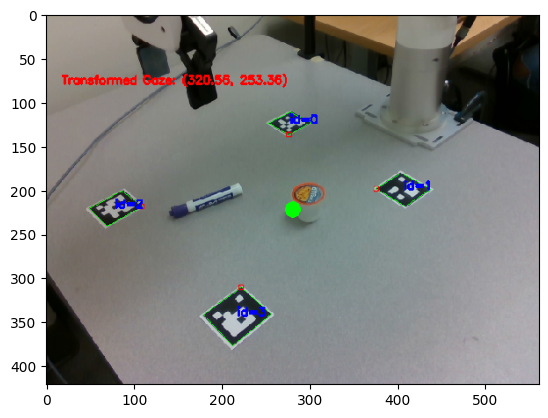

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Image path
image_path = '/home/u-ril/project-tracey/streaming/baseofcoffee.png'
image = cv2.imread(image_path)

# Function to plot the 3D bounding box
def plot_bbox(image, y_min, x_min, y_max, x_max):
    # Create a figure
    fig, ax = plt.subplots()

    # Plot the original image
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Define the corners of the bounding box
    corners = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

    box = plt.Polygon(corners, fill=None, edgecolor='red')
    ax.add_patch(box)

    plt.show()

coords = [500, 277, 550, 373]
y_min, x_min, y_max, x_max= coords[0]/1000*image.shape[1], coords[1]/1000*image.shape[0], coords[2]/1000*image.shape[1], coords[3]/1000*image.shape[0]

# Plot the bounding box
plot_bbox(image, y_min, x_min, y_max, x_max)
